I'd like to experiment with the pscore_match code, at https://github.com/kellieotto/pscore_match. This appears to have both propensity score generation and matching.

It's an alpha package, and it's not on pypi, but I was able to install directly from git using pip, like this:

     pip install git+https://github.com/kellieotto/pscore_match.git
     
Alternatively, for running the code from a local set of source, for example, from a Git repo, I uninstalled the above copy and then ran the following from the directory w/ the source:

    sudo python setup.py develop

The develop flag works like the normal 'install' flag, but instead of copying files to the typical site-packages location, it creates a pointer to the local source. I can confirm this by running look at the underscore underscore path underscore underscore property as shown below.

In [1]:
import sys
sys.path

['',
 '/Users/andrewenfield/miniconda3/envs/anaconda/lib/python36.zip',
 '/Users/andrewenfield/miniconda3/envs/anaconda/lib/python3.6',
 '/Users/andrewenfield/miniconda3/envs/anaconda/lib/python3.6/lib-dynload',
 '/Users/andrewenfield/.local/lib/python3.6/site-packages',
 '/Users/andrewenfield/miniconda3/envs/anaconda/lib/python3.6/site-packages',
 '/Users/andrewenfield/miniconda3/envs/anaconda/lib/python3.6/site-packages/Sphinx-1.6.3-py3.6.egg',
 '/Users/andrewenfield/miniconda3/envs/anaconda/lib/python3.6/site-packages/aeosa',
 '/Users/andrewenfield/work/github/pscore_match',
 '/Users/andrewenfield/miniconda3/envs/anaconda/lib/python3.6/site-packages/IPython/extensions',
 '/Users/andrewenfield/.ipython']

And I'll try the demo stuff at http://www.kellieottoboni.com/pscore_match/examples/ggi.html.

In [2]:
# just load the module to make reloads easier
#from pscore_match.pscore import PropensityScore
#from pscore_match.match import Match, whichMatched
import pscore_match.pscore
import pscore_match.match

from scipy.stats import gaussian_kde
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import plotly # for single plot comparing matched covariates

%matplotlib inline

/Users/andrewenfield/miniconda3/envs/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
pscore_match.__path__

['/Users/andrewenfield/work/github/pscore_match/pscore_match']

In [4]:
imai = pd.read_table('https://raw.githubusercontent.com/kellieotto/pscore_match/master/pscore_match/data/GerberGreenImai.txt', sep = '\s+')
imai.shape

(10829, 26)

In [5]:
imai.index = range(imai.shape[0])
imai[:3]

,PERSONS,WARD,QUESTION,MAILGRP,PHONEGRP,PERSNGRP,APPEAL,CONTACT,MAILINGS,AGE,...,DISMC,DISPHN,PHNC,PHNTRT1,PHNTRT2,PHNC1,PHNC2,NEW,phone,AGE2
0,2,13,0,0,1,0,3,0,0,74,...,99,1,1,1,1,1,1,0,1,54.76
1,2,24,1,0,1,0,3,0,0,37,...,99,1,1,1,1,1,1,0,1,13.69
2,2,29,1,0,1,0,2,0,0,24,...,99,1,1,1,1,1,1,0,1,5.76


In [6]:
# interaction terms
imai['PERSONS1_VOTE961'] = (imai.PERSONS==1)*imai.VOTE961
imai['PERSONS1_NEW'] = (imai.PERSONS==1)*imai.NEW

If I'm reading the ggi page correctly, the original Gerber-Green study was designed to call people with one of two messages: for a control, people received a message about civic duty, and for a treatment they received a message about the electoral race. If the  randomization worked correctly (it didn't), we'd expect that roughly the same proportion of people would answer the phone and hear the message in both groups. Actually, those that received the electoral race message were 10% less likely to answer the phone. Because of this imbalance, we can't know if differences in voter turnout between the control and treatment groups (the result/effect) were because of the message or because of fundamental other difference(s) (that also caused the groups to be different in how likely they were to answer the phone).

The dataset above includes control observations - people that got the civic duty message - and treatment observations - people that got the electoral race message - as long as they answered the phone... that is, everyone in the list answered the phone. I believe this is represented by the PHNC1 column, with 1 for treatments. 

The Imai follow-up attempted to correct for this imbalance after the fact by selecting a subset of the control observations, that answered the phone, and that were 'like' the treatment observations in terms of the specified covariates. We'd expect to see that, without matching, the distribution of propensity scores between control and treatment is different, while after matching, the distribution of propensity scores from the selected matching subset of controls is similar to the distribution of the treatment observations.   

In [7]:
treatment = np.array(imai.PHNC1)

cov_list = ['PERSONS', 'VOTE961', 'NEW', 'MAJORPTY', 'AGE', 'WARD', 'AGE2', 'PERSONS1_VOTE961', 'PERSONS1_NEW']
covariates = imai[cov_list]

In [8]:
type(treatment)

numpy.ndarray

In [9]:
type(covariates)

pandas.core.frame.DataFrame

In [10]:
pscore_match

<module 'pscore_match' from '/Users/andrewenfield/work/github/pscore_match/pscore_match/__init__.py'>

In [11]:
# import importlib
# importlib.reload(pscore_match.pscore)

In [12]:
pscore = pscore_match.pscore.PropensityScore(treatment, covariates).compute()
pscore

array([ 0.04315267,  0.02168222,  0.02596058, ...,  0.01979801,
        0.05479772,  0.03370652])

In [15]:
pd.Series(treatment).value_counts(dropna=False)

0    10582
1      247
dtype: int64

The Imai paper found five controls for each treatment, with replacement.

In [16]:
pairs = pscore_match.match.Match(treatment, pscore)
pairs.create(method='many-to-one', many_method='knn', k=5, replace=True)

What to get from pairs? There's no docs for the properties of a Match instance, from what I can see. I can poke around, and I can look at the source. For now I'll just show a few things.

In [17]:
[name for name in dir(pairs) if not name.startswith('__')] 

['_match_info',
 '_match_many',
 '_match_one',
 'create',
 'freq',
 'groups',
 'matches',
 'ncontrol',
 'nobs',
 'ntreat',
 'plot_balance',
 'propensity',
 'weights']

In [18]:
pairs.matches.keys()

dict_keys(['match_pairs', 'treated', 'control', 'dropped'])

The whichMatched function 'converts the output of Matches to a DataFrame with all matched observations'. It takes the Match object, and - key - a dataframe with the data we want to be able to look at. It filters this dataframe to show only the treatment observations and any matched controls, dropping controls that aren't matched.

Or at least that's how I think this is working. I want to confirm it and be able to pull out the exact rows/IDs of the observations selected to match. To start w/ this, I added what I think is a good ID value to the starting dataframe that whichMatched will filter - I called it 'id_maybe' because I'm not 100% sure that this is actually an ID. It does appear to match the index value. I'll look at the results of this below.

Also, it's possible that the data in the pairs object - for example, in the matches key - could have the matching rows.

In [19]:
all_observations_orig = pd.DataFrame({'pscore': pscore, 'treatment': treatment, 'voted': imai.VOTED98, 'id_maybe': imai.index})
# and then add in all of the original columns, so we do covariate comparison easily below; this duplicates a few cols but I'll leave this as is now so I don't have to change the names below
all_observations = pd.concat([all_observations_orig, imai], axis=1)
all_observations.shape

(10829, 32)

In [20]:
all_observations[:5]

,id_maybe,pscore,treatment,voted,PERSONS,WARD,QUESTION,MAILGRP,PHONEGRP,PERSNGRP,...,PHNC,PHNTRT1,PHNTRT2,PHNC1,PHNC2,NEW,phone,AGE2,PERSONS1_VOTE961,PERSONS1_NEW
0,0,0.043153,1,1,2,13,0,0,1,0,...,1,1,1,1,1,0,1,54.76,0,0
1,1,0.021682,1,0,2,24,1,0,1,0,...,1,1,1,1,1,0,1,13.69,0,0
2,2,0.025961,1,1,2,29,1,0,1,0,...,1,1,1,1,1,0,1,5.76,0,0
3,3,0.050916,1,1,2,10,1,0,1,0,...,1,1,1,1,1,0,1,65.61,0,0
4,4,0.007089,1,0,2,21,0,0,1,0,...,1,1,1,1,1,1,1,11.56,0,0


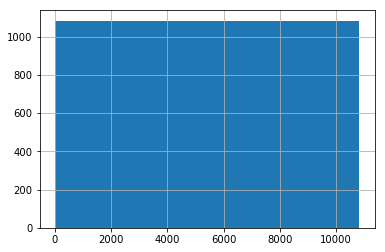

In [21]:
all_observations['id_maybe'].hist()

In [22]:
pd.crosstab(all_observations['treatment'], all_observations['voted'], margins=True)

voted,0,1,All
treatment,,,
0,5881,4701,10582
1,87,160,247
All,5968,4861,10829


In [23]:
data_matched = pscore_match.match.whichMatched(pairs, all_observations)
data_matched.shape

(1482, 32)

In [24]:
pd.crosstab(data_matched['treatment'], data_matched['voted'], margins=True)

voted,0,1,All
treatment,,,
0,524,711,1235
1,87,160,247
All,611,871,1482


In [25]:
data_matched[:5]

,id_maybe,pscore,treatment,voted,PERSONS,WARD,QUESTION,MAILGRP,PHONEGRP,PERSNGRP,...,PHNC,PHNTRT1,PHNTRT2,PHNC1,PHNC2,NEW,phone,AGE2,PERSONS1_VOTE961,PERSONS1_NEW
0,0,0.043153,1,1,2,13,0,0,1,0,...,1,1,1,1,1,0,1,54.76,0,0
1,1,0.021682,1,0,2,24,1,0,1,0,...,1,1,1,1,1,0,1,13.69,0,0
2,2,0.025961,1,1,2,29,1,0,1,0,...,1,1,1,1,1,0,1,5.76,0,0
3,3,0.050916,1,1,2,10,1,0,1,0,...,1,1,1,1,1,0,1,65.61,0,0
4,4,0.007089,1,0,2,21,0,0,1,0,...,1,1,1,1,1,1,1,11.56,0,0


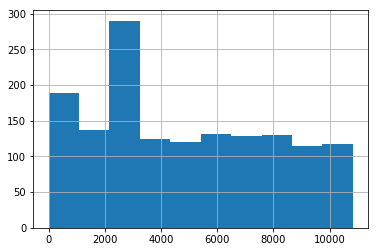

In [26]:
pd.Series(data_matched.index.values).hist()

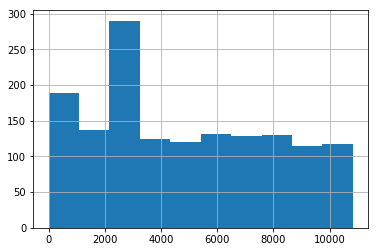

In [27]:
data_matched['id_maybe'].hist()

Why are we getting rows w/ the same IDs, scores, and treatment and voted values? We don't have that above w/ the first few rows. But here we have many (not all) with two or more - for ex, two 385s, two 398s, only one 509 and only one 517, four 554s. Shouldn't we just have a subset of the original all_observations dataframe, which doesn't have duplicates? 

Or... perhaps what we have here is the result of saying that we're doing it with replacement. If that's true, then the treatment rows should have no dupes - all the dupes should be in the selected controls. This is true, as shown below. In addition, if I do the matching without replacement, then I don't see any duplicates.

In [28]:
data_matched[100:110]

,id_maybe,pscore,treatment,voted,PERSONS,WARD,QUESTION,MAILGRP,PHONEGRP,PERSNGRP,...,PHNC,PHNTRT1,PHNTRT2,PHNC1,PHNC2,NEW,phone,AGE2,PERSONS1_VOTE961,PERSONS1_NEW
375,375,0.007088,0,0,2,23,0,0,0,0,...,0,0,0,0,0,1,0,22.09,0,0
385,385,0.042576,0,1,2,21,1,0,0,0,...,0,0,0,0,0,0,0,47.61,0,0
385,385,0.042576,0,1,2,21,1,0,0,0,...,0,0,0,0,0,0,0,47.61,0,0
398,398,0.028800,0,1,2,18,0,0,0,0,...,0,0,0,0,0,0,0,28.09,0,0
398,398,0.028800,0,1,2,18,0,0,0,0,...,0,0,0,0,0,0,0,28.09,0,0
429,429,0.058208,0,1,2,21,1,0,0,0,...,0,0,0,0,0,0,0,64.00,0,0
429,429,0.058208,0,1,2,21,1,0,0,0,...,0,0,0,0,0,0,0,64.00,0,0
434,434,0.038197,0,1,2,5,1,0,0,0,...,0,0,0,0,0,0,0,54.76,0,0
434,434,0.038197,0,1,2,5,1,0,0,0,...,0,0,0,0,0,0,0,54.76,0,0
509,509,0.024301,0,1,2,19,1,0,0,0,...,0,0,0,0,0,0,0,27.04,0,0


In [29]:
data_matched[data_matched['treatment']==0]['id_maybe'].is_unique

False

In [30]:
data_matched[data_matched['treatment']==1]['id_maybe'].is_unique

True

What are the distributions of propensity scores for treatment and control, as smoothed KDE histograms, from all of the data and from only the matched data?

If the covariate balance is good - i.e., if both the treatment and control groups have similar distributions in the covariates - then the distribution of the propensity scores should be similar. The matching has done this, as shown by the second plot below.

This is a quickie update to show some covariate stuff too. 

In [31]:
def plot_before_after_distributions(title, field=None, axis_limits=[0,0.15,0,40]):
    if field == None:
        field = title
    
    density0 = gaussian_kde(all_observations[all_observations['treatment']==0][field])
    density1 = gaussian_kde(all_observations[all_observations['treatment']==1][field])
    density0_post = gaussian_kde(data_matched[data_matched['treatment']==0][field])
    density1_post = gaussian_kde(data_matched[data_matched['treatment']==1][field])
    
    #plt.figure(1)
    plt.subplot(121)
    xs = np.linspace(axis_limits[0], axis_limits[1], 200)

    plt.plot(xs, density0(xs), color='black')
    plt.fill_between(xs, density1(xs), color='gray')
    plt.title('Phone: before matching')
    plt.axis(axis_limits)
    plt.xlabel(title)
    plt.ylabel('Density')
    plt.legend(['Control','Treatment'])
    
    plt.subplot(122)
    plt.plot(xs, density0_post(xs), color='black')
    plt.fill_between(xs, density1_post(xs), color='gray')
    plt.title('Phone: after matching')
    plt.axis(axis_limits)
    plt.xlabel(title)
    plt.ylabel('Density')
    plt.legend(['Control','Treatment'])   
    
    plt.show()

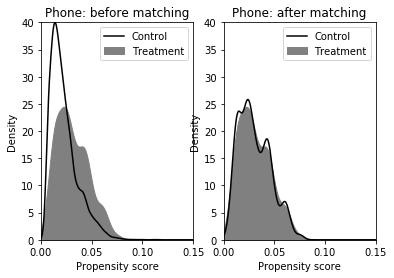

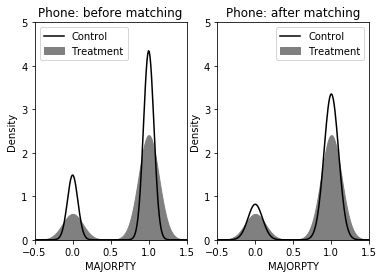

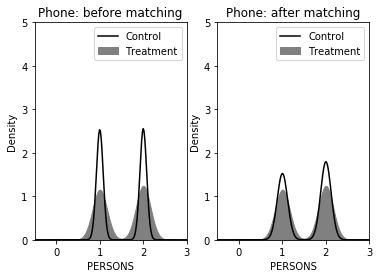

[None, None, None]

In [32]:
plot_specs = [{'title':'Propensity score', 'field':'pscore', 'axis_limits':[0,0.15,0,40]},
              {'title':'MAJORPTY', 'axis_limits':[-0.5,1.5,0,5]},
              {'title':'PERSONS', 'axis_limits':[-0.5,3,0,5]}]

[plot_before_after_distributions(**spec) for spec in plot_specs]

The above only shows that the distributions of the propensity scores match. This is useful, because in many cases the propensity score is a good proxy for the covariates (or, it may be, if I did/didn't understand the original paper). However, we also probably want to check that the distributions of the covariates themselves match. One way to compare covariates is just to do what we did above, but use as input the distribution of covariate A, then covariate B, etc. Another option is to do statistical tests - the plot_balance call does this. It outputs a saved file that has HTML using a Plotly plot. For now, I'm just leaving this as and need to open and view the content.

In the file itself, the plot shows the p-values from a set of two-sided t-tests. The author says the following of this plot:

> Important note: I don’t “believe” the p-values coming out of these tests, in the sense that the necessary assumptions are definitely violated. However, they can serve as a crude measure of how similar the treatment and control group distributions are. A “small” p-value suggests that they’re very different.
    
In practice, the p-values for all but one of the covariates are small to very small before matching, and much larger after matching, which she says is an indication that the distributions are similar.

In [50]:
pairs.plot_balance(covariates, filename='ggi-balance.html', auto_open=False)

The bottom of the http://www.kellieottoboni.com/pscore_match/examples/ggi.html page also has a short example of estimating treatment effects.